# Curve fitting

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle

In [2]:
img = mpimg.imread('./test_images/test3.jpg')

In [3]:
camera_cal = pickle.load( open( "camera_cal.p", "rb" ) )
ret = camera_cal[0]
mtx = camera_cal[1]
dist = camera_cal[2]


In [4]:
#MAKE SURE THAT THE TF MATRIX WAS SAVED FOR THE PROPER IMG SIZE
pers_tf = pickle.load(open( "M_Minv.p", "rb" ) )
M = pers_tf[0]
Minv = pers_tf[1]
print(M)

[[ -4.41022051e-01  -9.46797340e-01   6.71018551e+02]
 [ -1.66533454e-16  -1.48932447e+00   6.85649282e+02]
 [  1.95156391e-18  -2.43262163e-03   1.00000000e+00]]


In [5]:
def pipeline(img):
    
    sx_thresh=(30,75)
    s_thresh=(170, 230)
    u_thresh=(0,80)
    z_thresh=(240,255)

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv).astype(np.float)
    xyz = cv2.cvtColor(img, cv2.COLOR_BGR2XYZ).astype(np.float)

    sobel_kernel = 5

    sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F,1,0,ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel=np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # sobelxx = cv2.Sobel(abs_sobelx, cv2.CV_64F,1,0,ksize = 3)
    # abs_sobelxx = np.absolute(sobelxx)

    #Threshold sx gradient
    sx_binary = np.zeros_like(hls[:,:,2])
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] =1

    #Threshold s_color channel
    s_binary = np.zeros_like(hls[:,:,2])
    s_binary[(hls[:,:,2] >= s_thresh[0]) & (hls[:,:,2] <= s_thresh[1])] = 1

    #Threshold u_color channel
    u_binary = np.zeros_like(luv[:,:,1])
    u_binary[(luv[:,:,1] >= u_thresh[0]) & (luv[:,:,1] <= u_thresh[1])] = 1

    #Threshold z_color channel
    z_binary = np.zeros_like(xyz[:,:,2])
    z_binary[(xyz[:,:,2] >= z_thresh[0]) & (xyz[:,:,2] <= z_thresh[1])] = 1


    uz_binary = np.zeros_like(xyz[:,:,2])
    uz_binary[(u_binary ==1) | (z_binary==1)]=1
    #Stach each channel
    color_binary = np.dstack((uz_binary, sx_binary, s_binary))
    
    #OR each channel
    OR_binary = np.zeros_like(xyz[:,:,2])
    OR_binary[(uz_binary ==1) | (sx_binary ==1) | (s_binary ==1)] =1
    return OR_binary

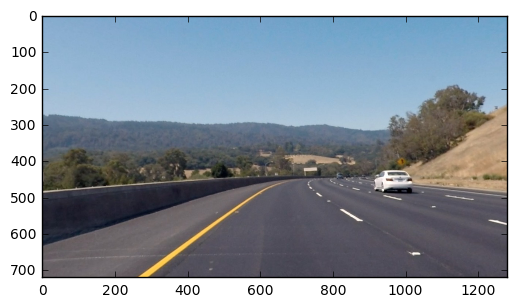

In [6]:
#undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)
#filter
res = pipeline(dst)
#perspective tf
warp_img_size = (800,600)
warped = cv2.warpPerspective(res, M, warp_img_size, flags=cv2.INTER_LINEAR)
# plt.imshow(warped,cmap='bone')

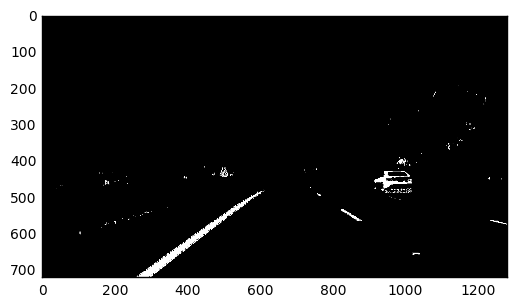

In [7]:
plt.imshow(res,cmap='bone')

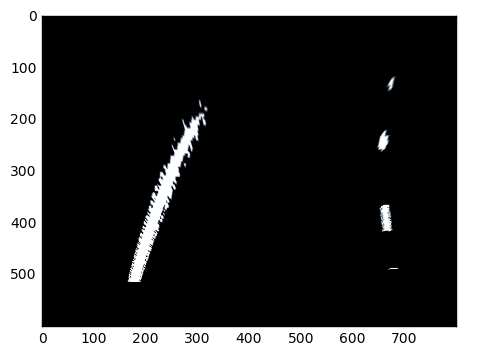

In [8]:
plt.imshow(warped,cmap='bone')

left lane:  220 -- right lane:  662


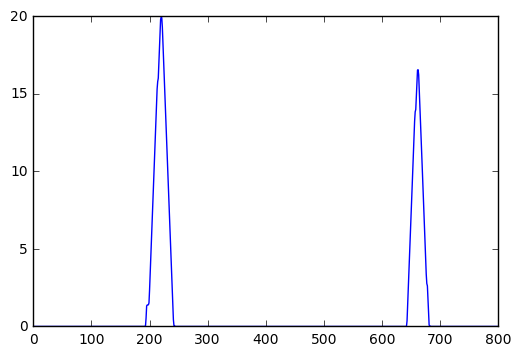

In [11]:
#Example of a one dimension convolution with a 20pt window
#This is effectively taking a moving average by sliding the window around and summing the functions.
window = np.zeros_like(warped[0,:])
win_size = 20
# window[390:410] = 1.0
window[int(len(warped[0])/2-win_size/2):int(len(warped[0])/2+win_size/2)] = 1.0
conv = np.convolve(warped[380,:],window,mode='same')
# plt.imshow(warped[350:400,:],cmap='bone')
plt.plot(conv)
print('left lane: ', np.argmax(conv[0:500]),'-- right lane: ',np.argmax(conv[300:800])+300 )

It is tempting to use a 2D convolution with say, a sinc funtion to get a moving average in both dimensions. Then find the peaks from that to fit a curve to. Not for now..

Instead try taking the average of the peaks from the 1D convolutions for x-lines around a point.

Python doesn't seem to have a great peak detection algorithm. Scipy's wavelet based approach seems too complex for now. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html
We may come back to this. Let's just use np.argmax for now on each side of the picture and see how that goes

In [20]:
# Find the peaks
## warped image size is currently hardcoded
# x: >
# y: v

win_y = 8 
win_x = 20
#detection threshold = increase probability of line detection, sensitivity to noise
peak_thresh = 10 #threshold for detecting a peak in a single convolution line Note win_x size = 20  12/20 = 60% of pixels
peak_thresh = peak_thresh*win_y  #threshold for detecting a peak over the y_window

x_left = list()
y_left = list()
x_right = list()
y_right = list()

window[int(len(warped[0])/2-win_x/2):int(len(warped[0])/2+win_x/2)] = 1.0

y_ind = win_y/2
# y_ind = 220
# print(len(warped))
while y_ind < len(warped):
    #zero the conv variable
    conv=np.zeros_like(warped[0])
#     print ('derp+', y_ind)

    #sum all the 1d convolutions around the y point of interest -win_y/2 .. + win_y/2
    for yi in range(win_y):
        ind = int(y_ind - win_y/2 + yi)
#         print (ind)
        conv = conv + np.convolve(warped[ind,:],window,mode='same')
    
    #detect peaks and indices --looking for one or two peaks
    #how to differentiate left lane from right lane? - start with left side of img vs right..sucks
    
    if (np.max(conv[0:400])>peak_thresh):
        x_l = np.argmax(conv[0:400])
        y_l = y_ind
        x_left.append(x_l)
        y_left.append(y_l)
    if (np.max(conv[400:800])>peak_thresh):    
        x_r = (np.argmax(conv[400:800])+400)
        y_r = y_ind
        x_right.append(x_r)
        y_right.append(y_r)
    
    y_ind=y_ind+win_y/2
        

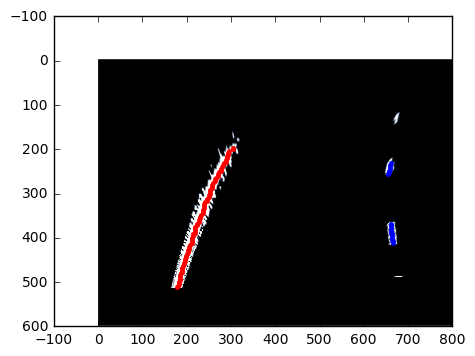

In [21]:
plt.imshow(warped,cmap='bone')
plt.plot(x_left,y_left,'r.')
plt.plot(x_right,y_right,'b.')

In [22]:

# print((yvals))

In [23]:
#Using the code from the course.. because it is there
offset = 100 #offset used in the perspective transform
y_size = np.shape(warped)[0]#size of the warped image y axis

yvals = np.linspace(offset, y_size-offset)
left_fit = np.polyfit(y_left, x_left, 2)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]

right_fit = np.polyfit(y_right, x_right, 2)
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

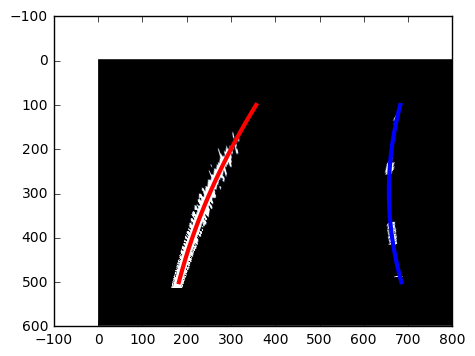

In [24]:
plt.imshow(warped,cmap='bone')
plt.plot(left_fitx,yvals,'r',linewidth=3)
plt.plot(right_fitx,yvals,'b',linewidth=3)

In [60]:
ym_per_pix = 30.0/400 # meters per pixel in y dimension
xm_per_pix = 3.7/550 # meteres per pixel in x dimension

y_eval = 450

left_fit_cr = np.polyfit(np.array(y_left)*ym_per_pix, np.array(x_left)*xm_per_pix, 2)
right_fit_cr = np.polyfit(np.array(y_right)*ym_per_pix, np.array(x_right)*xm_per_pix, 2)

left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1580.05034802 m 1385.91181991 m


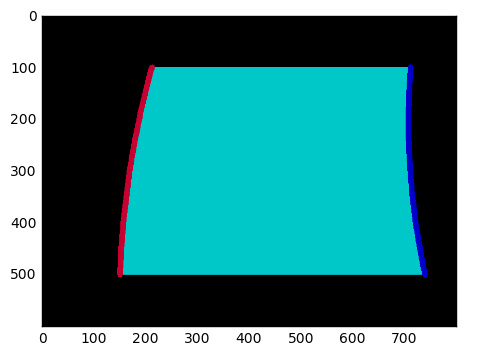

In [61]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,200, 200))
cv2.polylines(color_warp,np.int_([pts_left]),isClosed=False,color=(200,0,50),thickness=10)
cv2.polylines(color_warp,np.int_([pts_right]),isClosed=False,color=(0,0,200),thickness=10)
plt.imshow(color_warp)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (dst.shape[1], dst.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)
# plt.imshow(result)

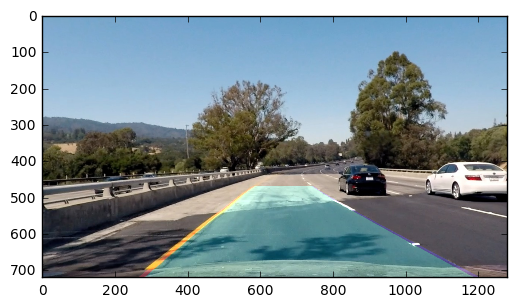

In [62]:
plt.imshow(result)

In [ ]:
#looks good!